# Notebook for Layer-wise analysis of NLP models

In this notebook we investigate in greater details the structure of each NLP models (LSTM and transformer-based) of the ModelComparison part.

In [2]:
import warnings
warnings.simplefilter(action='ignore')

import os
import gc
import glob
import itertools
from tqdm import tqdm
from itertools import combinations
from joblib import Parallel, delayed

import umap
import scipy
import hdbscan
import nistats
import numpy as np
import pandas as pd
from sklearn import manifold
from sklearn.decomposition import PCA, FastICA
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import AgglomerativeClustering, KMeans

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import nibabel as nib
import nilearn
from nilearn.image import load_img, mean_img, index_img, threshold_img, math_img, smooth_img, new_img_like
from nilearn.input_data import NiftiMapsMasker, NiftiMasker, NiftiLabelsMasker, MultiNiftiMasker
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting
from nilearn import datasets
from scipy.stats import norm
from nilearn.surface import vol_to_surf

import utils 
import reporting
from logger import Logger
from linguistics_info import load_surnames, load_syntactic_roi, load_language_roi

### Paths

In [3]:
language = 'english'
model_names = ['bert-base-cased_pre-7_1_post-0_norm-None', 'gpt2_pre-20_1_norm-inf']

In [4]:
PROJECT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/"
OUTPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/{language}"
INPUT_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/stimuli-representations/{language}"
FMRIDATA_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/data/fMRI/{language}"
MASKER_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/global_masker_95%_{language}"
ALL_MASKS_PATH = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/ROI_masks/"
SAVING_FOLDER = f"/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/clustering/{language}"
TMP_FOLDER = f"/home/ap259944/tmp"

In [5]:
#PROJECT_PATH = f"/Users/alexpsq/Code/Parietal/maps"
#INPUT_PATH = f"/Users/alexpsq/Code/Parietal/data/stimuli-representations/english"

### Maskers

In [6]:
logger = Logger(os.path.join(PROJECT_PATH, 'logs.txt'))

global_masker_50 = reporting.fetch_masker(f"{ALL_MASKS_PATH}/global_masker_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)
global_masker_95 = reporting.fetch_masker(f"{ALL_MASKS_PATH}/global_masker_95%_{language}"
, language, FMRIDATA_PATH, INPUT_PATH, smoothing_fwhm=None, logger=logger)


original_masker = global_masker_50
new_masker = global_masker_95
original_masker.set_params(detrend=False, standardize=False)
new_masker.set_params(detrend=False, standardize=False)


NiftiMasker(detrend=False, dtype=None, high_pass=None, low_pass=None,
            mask_args=None,
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f2d068097d0>,
            mask_strategy='background', memory=Memory(location=None),
            memory_level=0, reports=True, sample_mask=None, sessions=None,
            smoothing_fwhm=None, standardize=False, t_r=None,
            target_affine=None, target_shape=None, verbose=0)

### Atlas

In [7]:
atlas_maps, labels = reporting.load_atlas() # load harvard-oxford atlas named'cort-prob-2mm'

### Activations homogeneity in attention heads

In [22]:
model_name = model_names[0]

In [23]:
# Fetching model activations
all_data = [pd.read_csv(os.path.join(INPUT_PATH, model_name, 'activations_run{index}.csv'.format(index=index))) for index in range(1, 10)]


In [24]:
data_ = [data_tmp[data_tmp.columns[:768*13]] for data_tmp in all_data] # only keep hidden states
#data_ = [data_tmp[data_tmp.columns[768*13:]] for data_tmp in all_data] # only keep attention states
data = pd.concat(data_)

In [26]:
data_pca = reporting.aggregate_beta_maps(data.values, nb_layers=13, layer_size=768, attention_head_size=64, nb_attention_heads=12, aggregation_type='pca', n_components=100)
data_layer = reporting.aggregate_beta_maps(data.values, nb_layers=13, layer_size=768, attention_head_size=64, nb_attention_heads=12, aggregation_type='layer')
data_attention = reporting.aggregate_beta_maps(data.values, nb_layers=13, layer_size=768, attention_head_size=64, nb_attention_heads=12, aggregation_type='attention_head')


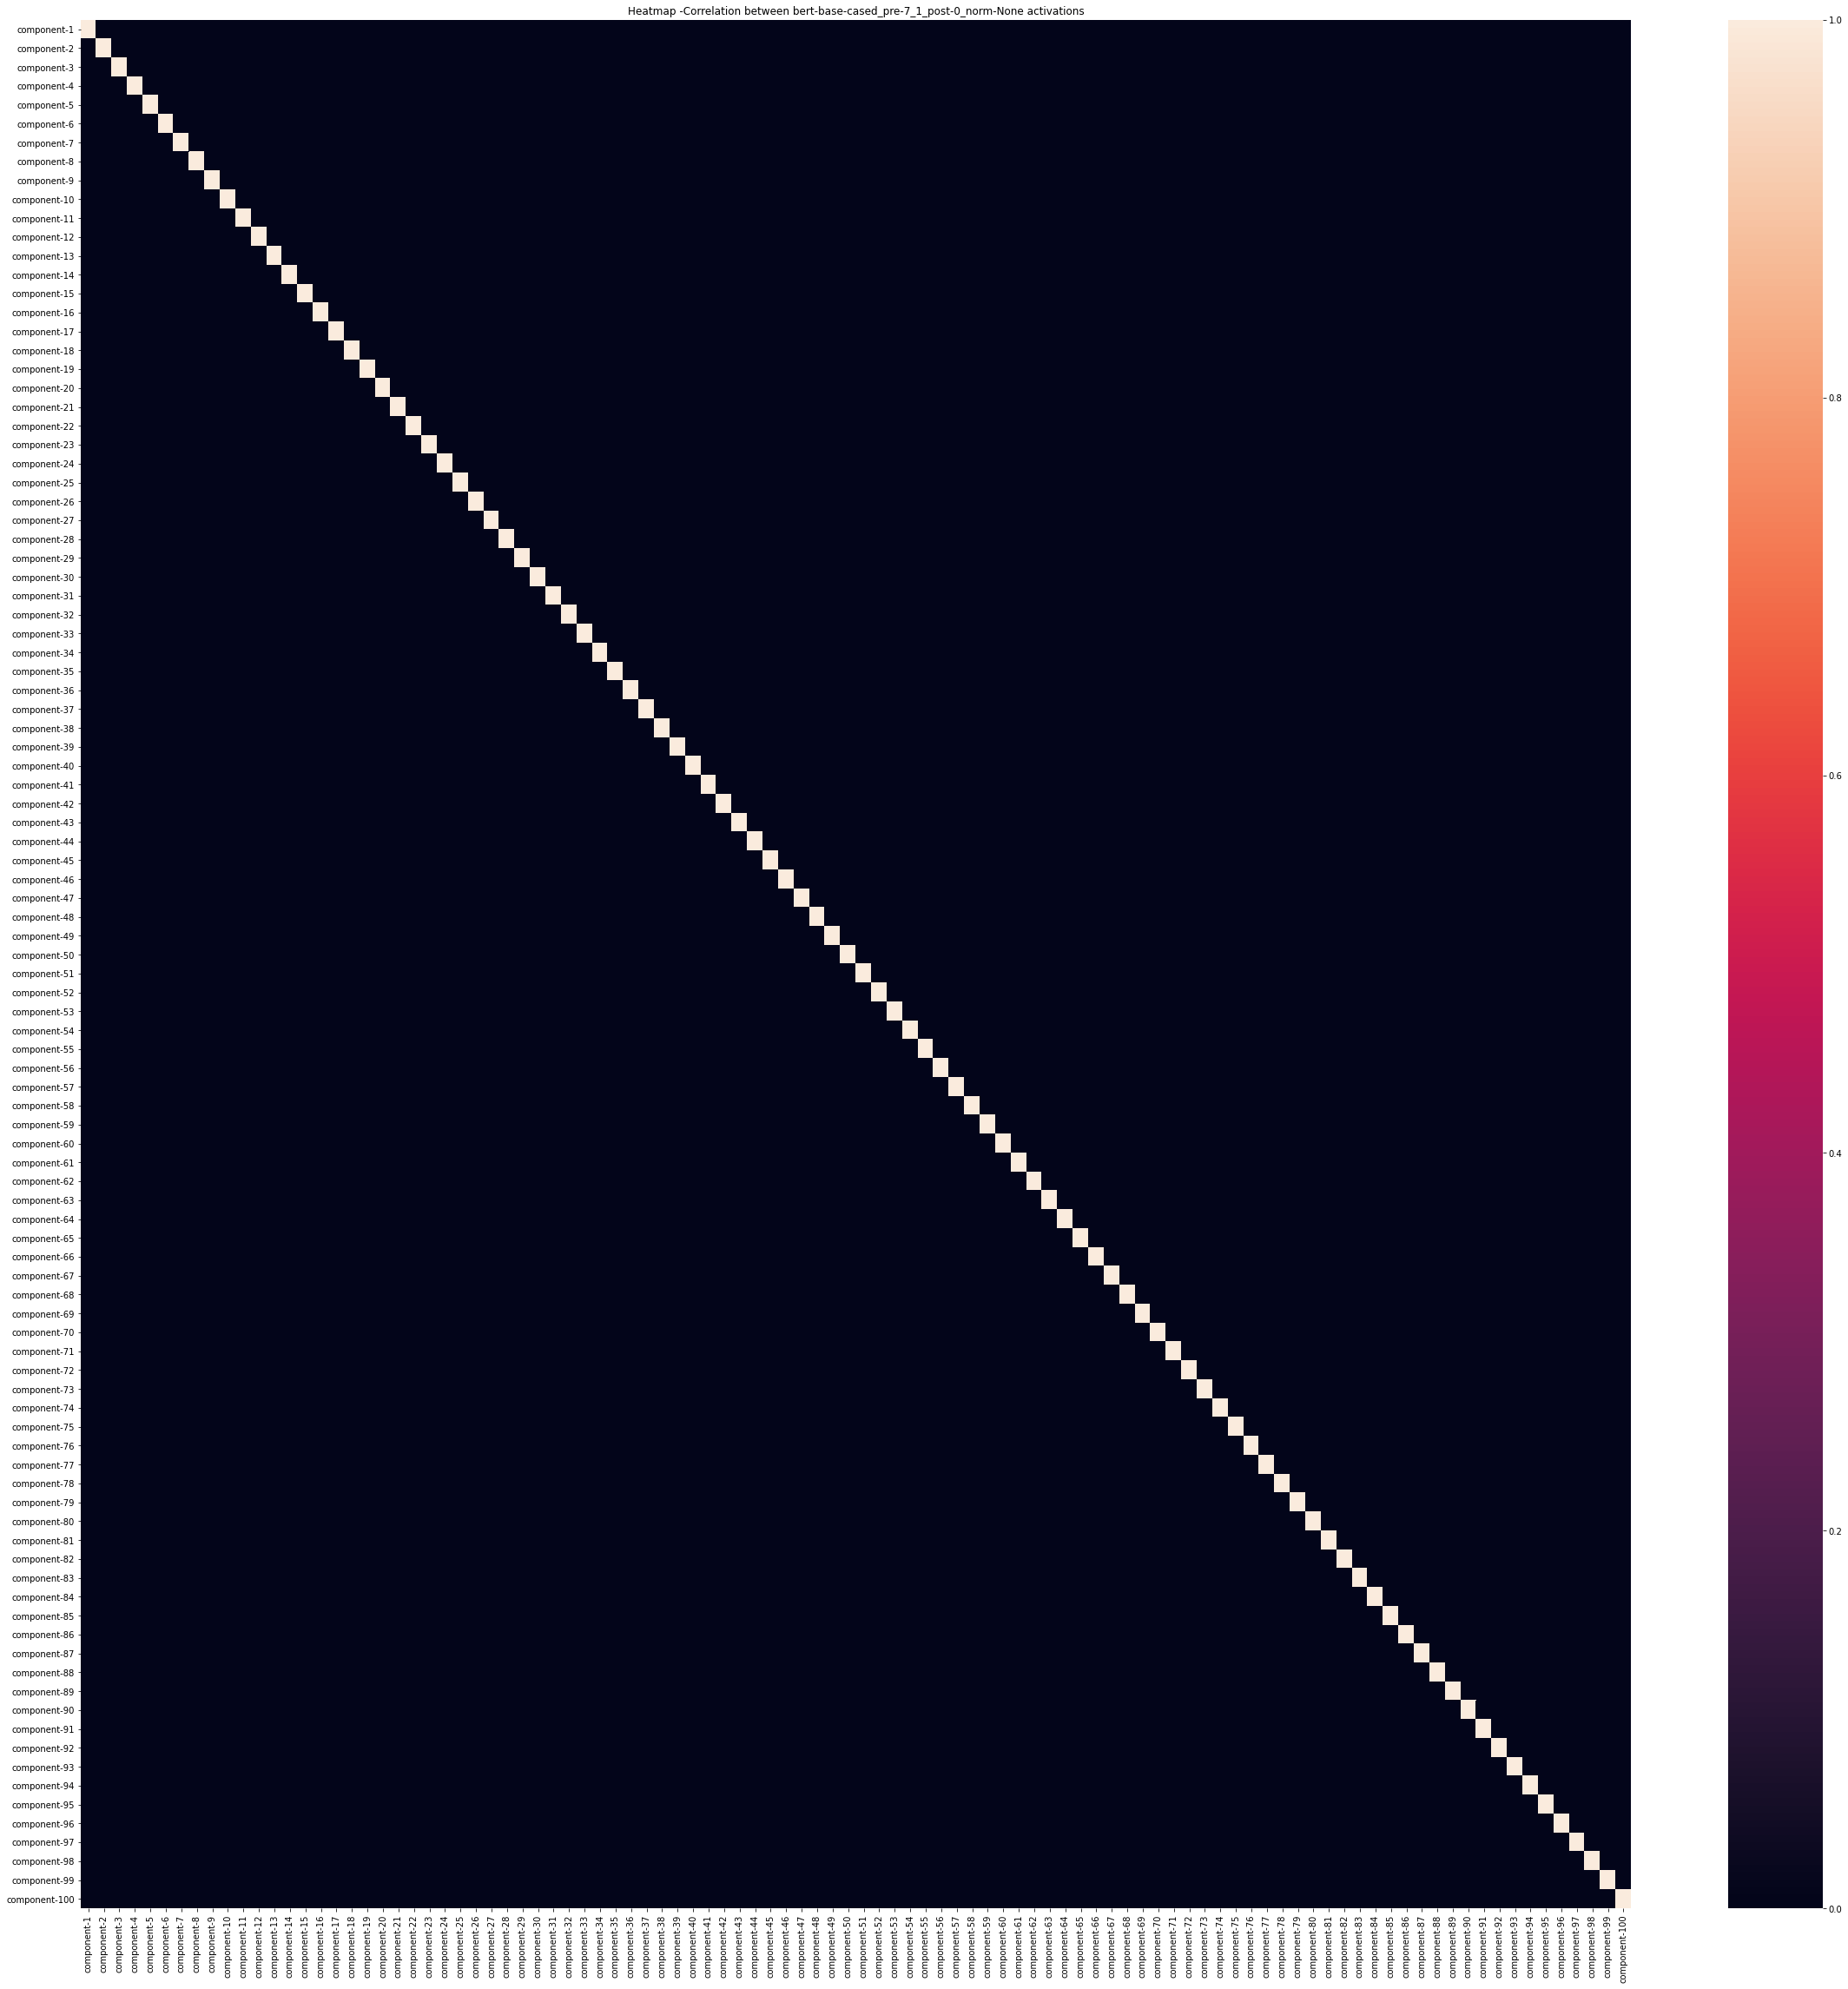

In [28]:
name = f'Correlation between {model_name} activations'
reporting.heat_map(pd.DataFrame(data_pca, columns=['component-{}'.format(index) for index in range(1, data_pca.shape[1]+1)]).corr(), aggregate=False, title=name, saving_path=None) #SAVING_FOLDER, name + '.png'


### Layer wise analysis

In [10]:
layer_analysis_model_names = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0'
]

In [11]:
analysis_layers = {
    'Hidden-layers': 'hidden-layer-*'}

In [12]:
#data_full = reporting.get_model_data(model_names, language, OUTPUT_PATH)
#data_model_comparison = { key.replace('_{}', ''): data_full[key.replace('_{}', '')] for key in model_names }

data_layers = reporting.get_layers_data(
                        layer_analysis_model_names, 
                        analysis=analysis_layers, 
                        language='english',
                        OUTPUT_PATH=OUTPUT_PATH
                        )

  2%|▏         | 1/51 [00:04<03:58,  4.78s/it]

sub-057 - 13 - 13


  4%|▍         | 2/51 [00:09<03:54,  4.78s/it]

sub-058 - 13 - 13


  6%|▌         | 3/51 [00:12<03:18,  4.14s/it]

sub-059 - 13 - 13


  8%|▊         | 4/51 [00:15<03:08,  4.00s/it]

sub-061 - 13 - 13


 10%|▉         | 5/51 [00:19<02:52,  3.75s/it]

sub-062 - 13 - 13


 12%|█▏        | 6/51 [00:24<03:06,  4.16s/it]

sub-063 - 13 - 13


 14%|█▎        | 7/51 [00:27<02:55,  3.98s/it]

sub-064 - 13 - 13


 16%|█▌        | 8/51 [00:33<03:09,  4.40s/it]

sub-065 - 13 - 13


 18%|█▊        | 9/51 [00:36<02:50,  4.07s/it]

sub-066 - 13 - 13


 20%|█▉        | 10/51 [00:38<02:22,  3.47s/it]

sub-067 - 13 - 13


 22%|██▏       | 11/51 [00:44<02:43,  4.09s/it]

sub-068 - 13 - 13


 25%|██▌       | 13/51 [00:44<01:24,  2.21s/it]

sub-069 - 13 - 13
sub-070 - 13 - 13


 27%|██▋       | 14/51 [00:47<01:21,  2.19s/it]

sub-072 - 13 - 13


 29%|██▉       | 15/51 [00:49<01:21,  2.27s/it]

sub-073 - 13 - 13


 31%|███▏      | 16/51 [00:50<01:01,  1.76s/it]

sub-074 - 13 - 13


 33%|███▎      | 17/51 [00:53<01:14,  2.18s/it]

sub-075 - 13 - 13


 35%|███▌      | 18/51 [00:53<00:55,  1.68s/it]

sub-076 - 13 - 13


 37%|███▋      | 19/51 [00:56<01:05,  2.04s/it]

sub-077 - 13 - 13


 39%|███▉      | 20/51 [00:57<00:53,  1.72s/it]

sub-078 - 13 - 13


 41%|████      | 21/51 [01:01<01:10,  2.34s/it]

sub-079 - 13 - 13


 43%|████▎     | 22/51 [01:02<00:53,  1.84s/it]

sub-080 - 13 - 13


 45%|████▌     | 23/51 [01:04<00:54,  1.96s/it]

sub-081 - 13 - 13


 47%|████▋     | 24/51 [01:07<00:59,  2.20s/it]

sub-082 - 13 - 13


 49%|████▉     | 25/51 [01:07<00:42,  1.62s/it]

sub-083 - 13 - 13


 51%|█████     | 26/51 [01:08<00:33,  1.36s/it]

sub-084 - 13 - 13


 53%|█████▎    | 27/51 [01:08<00:27,  1.14s/it]

sub-086 - 13 - 13


 55%|█████▍    | 28/51 [01:10<00:29,  1.30s/it]

sub-087 - 13 - 13


 57%|█████▋    | 29/51 [01:14<00:48,  2.22s/it]

sub-088 - 13 - 13


 59%|█████▉    | 30/51 [01:16<00:41,  1.96s/it]

sub-089 - 13 - 13


 61%|██████    | 31/51 [01:19<00:50,  2.50s/it]

sub-091 - 13 - 13


 65%|██████▍   | 33/51 [01:23<00:36,  2.05s/it]

sub-092 - 13 - 13
sub-093 - 13 - 13


 67%|██████▋   | 34/51 [01:25<00:34,  2.02s/it]

sub-094 - 13 - 13


 69%|██████▊   | 35/51 [01:27<00:29,  1.82s/it]

sub-095 - 13 - 13


 71%|███████   | 36/51 [01:27<00:20,  1.40s/it]

sub-096 - 13 - 13


 75%|███████▍  | 38/51 [01:29<00:14,  1.15s/it]

sub-097 - 13 - 13
sub-098 - 13 - 13


 76%|███████▋  | 39/51 [01:29<00:10,  1.13it/s]

sub-099 - 13 - 13


 80%|████████  | 41/51 [01:31<00:07,  1.36it/s]

sub-100 - 13 - 13
sub-101 - 13 - 13


 84%|████████▍ | 43/51 [01:33<00:06,  1.24it/s]

sub-103 - 13 - 13
sub-104 - 13 - 13


 86%|████████▋ | 44/51 [01:33<00:04,  1.64it/s]

sub-105 - 13 - 13


 88%|████████▊ | 45/51 [01:36<00:07,  1.24s/it]

sub-106 - 13 - 13


 90%|█████████ | 46/51 [01:37<00:06,  1.25s/it]

sub-108 - 13 - 13


 92%|█████████▏| 47/51 [01:37<00:03,  1.04it/s]

sub-109 - 13 - 13


 94%|█████████▍| 48/51 [01:40<00:04,  1.43s/it]

sub-110 - 13 - 13


 96%|█████████▌| 49/51 [01:40<00:02,  1.07s/it]

sub-113 - 13 - 13


 98%|█████████▊| 50/51 [01:40<00:00,  1.17it/s]

sub-114 - 13 - 13


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 13 - 13


  2%|▏         | 1/51 [00:00<00:10,  4.59it/s]

sub-057 - 13 - 13


  4%|▍         | 2/51 [00:02<00:35,  1.37it/s]

sub-058 - 13 - 13


  6%|▌         | 3/51 [00:06<01:33,  1.95s/it]

sub-059 - 13 - 13


  8%|▊         | 4/51 [00:08<01:21,  1.74s/it]

sub-061 - 13 - 13


 10%|▉         | 5/51 [00:08<01:00,  1.31s/it]

sub-062 - 13 - 13


 12%|█▏        | 6/51 [00:10<01:07,  1.50s/it]

sub-063 - 13 - 13


 14%|█▎        | 7/51 [00:14<01:35,  2.17s/it]

sub-064 - 13 - 13


 16%|█▌        | 8/51 [00:15<01:18,  1.82s/it]

sub-065 - 13 - 13


 18%|█▊        | 9/51 [00:18<01:36,  2.31s/it]

sub-066 - 13 - 13


 20%|█▉        | 10/51 [00:19<01:13,  1.80s/it]

sub-067 - 13 - 13


 24%|██▎       | 12/51 [00:22<01:01,  1.59s/it]

sub-068 - 13 - 13
sub-069 - 13 - 13


 25%|██▌       | 13/51 [00:25<01:11,  1.89s/it]

sub-070 - 13 - 13


 27%|██▋       | 14/51 [00:28<01:23,  2.26s/it]

sub-072 - 13 - 13


 29%|██▉       | 15/51 [00:28<01:04,  1.78s/it]

sub-073 - 13 - 13


 33%|███▎      | 17/51 [00:31<00:51,  1.51s/it]

sub-074 - 13 - 13
sub-075 - 13 - 13


 35%|███▌      | 18/51 [00:32<00:40,  1.23s/it]

sub-076 - 13 - 13


 37%|███▋      | 19/51 [00:35<01:00,  1.91s/it]

sub-077 - 13 - 13


 39%|███▉      | 20/51 [00:37<00:55,  1.80s/it]

sub-078 - 13 - 13


 41%|████      | 21/51 [00:39<00:52,  1.74s/it]

sub-079 - 13 - 13


 43%|████▎     | 22/51 [00:44<01:23,  2.90s/it]

sub-080 - 13 - 13


 45%|████▌     | 23/51 [00:46<01:11,  2.55s/it]

sub-081 - 13 - 13


 47%|████▋     | 24/51 [00:51<01:33,  3.45s/it]

sub-082 - 13 - 13


 49%|████▉     | 25/51 [00:54<01:22,  3.18s/it]

sub-083 - 13 - 13


 53%|█████▎    | 27/51 [00:55<00:43,  1.80s/it]

sub-084 - 13 - 13
sub-086 - 13 - 13


 55%|█████▍    | 28/51 [00:58<00:49,  2.14s/it]

sub-087 - 13 - 13


 57%|█████▋    | 29/51 [00:59<00:39,  1.79s/it]

sub-088 - 13 - 13


 59%|█████▉    | 30/51 [01:00<00:30,  1.46s/it]

sub-089 - 13 - 13


 61%|██████    | 31/51 [01:01<00:27,  1.37s/it]

sub-091 - 13 - 13


 63%|██████▎   | 32/51 [01:02<00:26,  1.40s/it]

sub-092 - 13 - 13


 65%|██████▍   | 33/51 [01:03<00:19,  1.08s/it]

sub-093 - 13 - 13


 67%|██████▋   | 34/51 [01:05<00:25,  1.51s/it]

sub-094 - 13 - 13


 69%|██████▊   | 35/51 [01:06<00:18,  1.18s/it]

sub-095 - 13 - 13


 71%|███████   | 36/51 [01:09<00:25,  1.71s/it]

sub-096 - 13 - 13


 75%|███████▍  | 38/51 [01:10<00:15,  1.18s/it]

sub-097 - 13 - 13
sub-098 - 13 - 13


 76%|███████▋  | 39/51 [01:15<00:28,  2.38s/it]

sub-099 - 13 - 13


 78%|███████▊  | 40/51 [01:15<00:19,  1.73s/it]

sub-100 - 13 - 13


 80%|████████  | 41/51 [01:18<00:20,  2.01s/it]

sub-101 - 13 - 13


 82%|████████▏ | 42/51 [01:19<00:15,  1.75s/it]

sub-103 - 13 - 13


 84%|████████▍ | 43/51 [01:24<00:20,  2.51s/it]

sub-104 - 13 - 13


 86%|████████▋ | 44/51 [01:26<00:17,  2.55s/it]

sub-105 - 13 - 13


 88%|████████▊ | 45/51 [01:29<00:15,  2.63s/it]

sub-106 - 13 - 13


 90%|█████████ | 46/51 [01:30<00:10,  2.05s/it]

sub-108 - 13 - 13


 92%|█████████▏| 47/51 [01:31<00:06,  1.70s/it]

sub-109 - 13 - 13


 96%|█████████▌| 49/51 [01:33<00:02,  1.27s/it]

sub-110 - 13 - 13
sub-113 - 13 - 13


 98%|█████████▊| 50/51 [01:35<00:01,  1.61s/it]

sub-114 - 13 - 13


100%|██████████| 51/51 [01:39<00:00,  1.94s/it]

sub-115 - 13 - 13


In [13]:
data_layers_to_plot = reporting.get_data_per_roi(
                                data_layers, 
                                atlas_maps,
                                labels,
                                analysis=analysis_layers, 
                                language='english', 
                                object_of_interest='Pearson_coeff',
                                attention_head_reordering=None,
                                threshold_img=None,
                                PROJECT_PATH=PROJECT_PATH
                                )

dict_keys(['models', 'hidden-layer-0', 'hidden-layer-1', 'hidden-layer-10', 'hidden-layer-11', 'hidden-layer-12', 'hidden-layer-2', 'hidden-layer-3', 'hidden-layer-4', 'hidden-layer-5', 'hidden-layer-6', 'hidden-layer-7', 'hidden-layer-8', 'hidden-layer-9'])


  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 97/97 [04:57<00:00,  3.07s/it]


		-->Done
		-->Done
dict_keys(['models', 'hidden-layer-0', 'hidden-layer-1', 'hidden-layer-10', 'hidden-layer-11', 'hidden-layer-12', 'hidden-layer-2', 'hidden-layer-3', 'hidden-layer-4', 'hidden-layer-5', 'hidden-layer-6', 'hidden-layer-7', 'hidden-layer-8', 'hidden-layer-9'])


  0%|          | 0/97 [00:00<?, ?it/s]

	Looping through labeled masks...


100%|██████████| 97/97 [01:56<00:00,  1.20s/it]

		-->Done
		-->Done


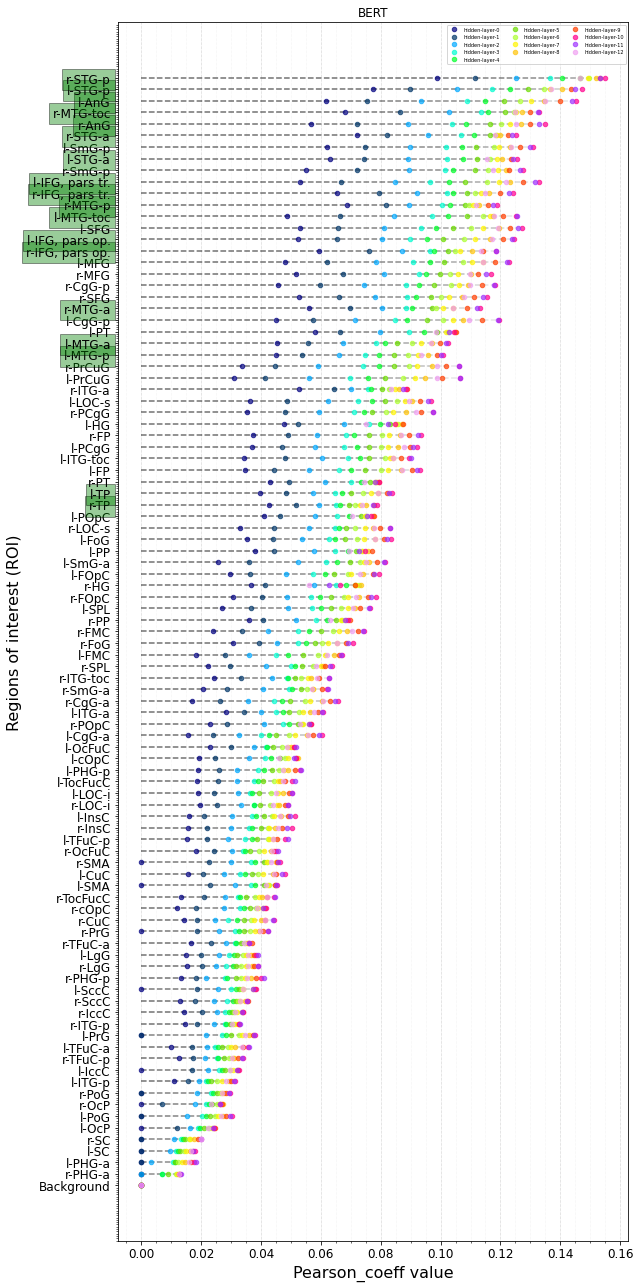

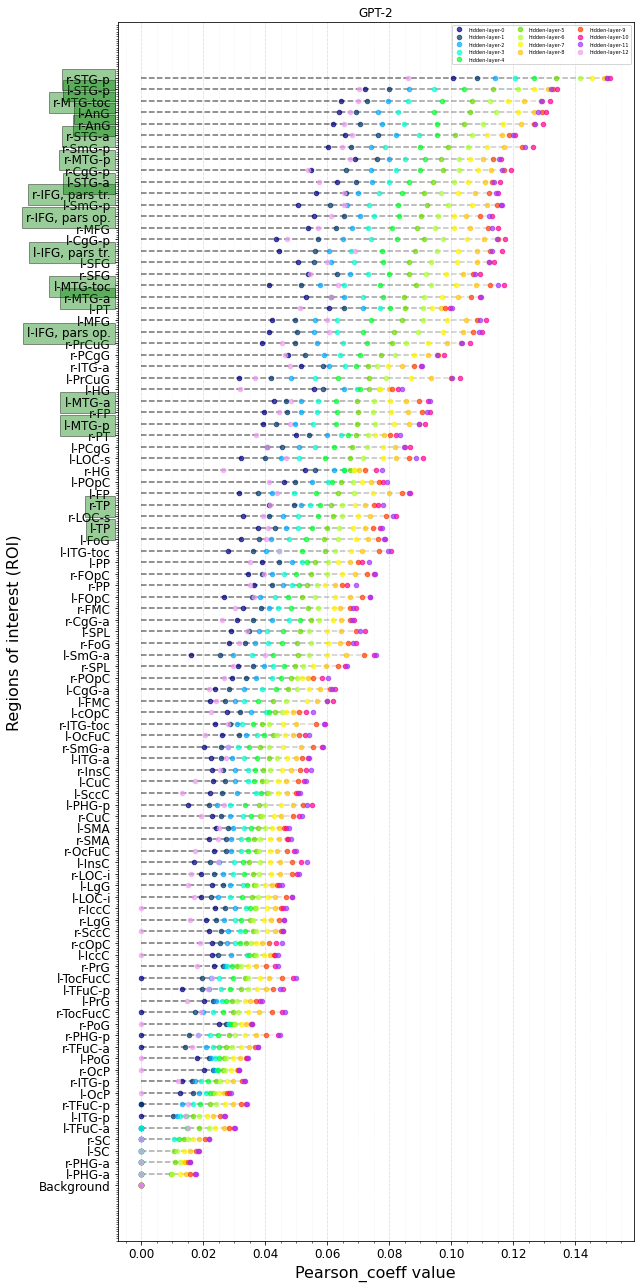

In [25]:
reporting.vertical_plot(
                data_layers_to_plot['Hidden-layers'][0]['third_quartile'], 
                labels, 
                'Third_Quartile_Pearson-coeff_per_ROI',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=data_layers_to_plot['Hidden-layers'][0]['models'], 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title='BERT', 
                ylabel='Regions of interest (ROI)', 
                xlabel='Pearson_coeff value', 
                model_name='Layers'
                )
reporting.vertical_plot(
                data_layers_to_plot['Hidden-layers'][1]['third_quartile'], 
                labels, 
                'Third_Quartile_Pearson-coeff_per_ROI',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=data_layers_to_plot['Hidden-layers'][1]['models'], 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title='GPT-2', 
                ylabel='Regions of interest (ROI)', 
                xlabel='Pearson_coeff value', 
                model_name='Layers'
                )

### Attention-head wise analysis

In [8]:
layer_analysis_model_names = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0'
]

In [9]:
analysis_attention_heads = {
    'Specific-attention-heads': 'attention-layer-*_head-*'}

In [10]:
data_attention_heads = reporting.get_layers_data(
                        layer_analysis_model_names, 
                        analysis=analysis_attention_heads, 
                        language='english',
                        OUTPUT_PATH=OUTPUT_PATH
                        )

  2%|▏         | 1/51 [00:00<00:10,  4.59it/s]

sub-057 - 144 - 144


  4%|▍         | 2/51 [00:00<00:11,  4.44it/s]

sub-058 - 144 - 144


  6%|▌         | 3/51 [00:00<00:11,  4.33it/s]

sub-059 - 144 - 144


  8%|▊         | 4/51 [00:00<00:11,  4.25it/s]

sub-061 - 144 - 144


 10%|▉         | 5/51 [00:01<00:10,  4.19it/s]

sub-062 - 144 - 144


 12%|█▏        | 6/51 [00:01<00:10,  4.21it/s]

sub-063 - 144 - 144


 14%|█▎        | 7/51 [00:01<00:10,  4.23it/s]

sub-064 - 144 - 144


 16%|█▌        | 8/51 [00:01<00:10,  4.28it/s]

sub-065 - 144 - 144


 18%|█▊        | 9/51 [00:02<00:10,  4.08it/s]

sub-066 - 144 - 144


 20%|█▉        | 10/51 [00:02<00:10,  4.06it/s]

sub-067 - 144 - 144


 22%|██▏       | 11/51 [00:02<00:09,  4.09it/s]

sub-068 - 144 - 144


 24%|██▎       | 12/51 [00:02<00:09,  4.07it/s]

sub-069 - 144 - 144


 25%|██▌       | 13/51 [00:03<00:09,  4.03it/s]

sub-070 - 144 - 144


 27%|██▋       | 14/51 [00:03<00:09,  4.07it/s]

sub-072 - 144 - 144


 29%|██▉       | 15/51 [00:03<00:08,  4.11it/s]

sub-073 - 144 - 144


 31%|███▏      | 16/51 [00:03<00:08,  4.16it/s]

sub-074 - 144 - 144


 33%|███▎      | 17/51 [00:04<00:08,  4.20it/s]

sub-075 - 144 - 144


 35%|███▌      | 18/51 [00:04<00:07,  4.36it/s]

sub-076 - 144 - 144


 37%|███▋      | 19/51 [00:04<00:07,  4.39it/s]

sub-077 - 144 - 144


 39%|███▉      | 20/51 [00:04<00:07,  4.36it/s]

sub-078 - 144 - 144


 41%|████      | 21/51 [00:05<00:06,  4.33it/s]

sub-079 - 144 - 144


 43%|████▎     | 22/51 [00:05<00:06,  4.49it/s]

sub-080 - 144 - 144


 45%|████▌     | 23/51 [00:05<00:06,  4.42it/s]

sub-081 - 144 - 144


 47%|████▋     | 24/51 [00:05<00:06,  4.29it/s]

sub-082 - 144 - 144


 49%|████▉     | 25/51 [00:05<00:06,  4.24it/s]

sub-083 - 144 - 144


 51%|█████     | 26/51 [00:06<00:05,  4.21it/s]

sub-084 - 144 - 144


 53%|█████▎    | 27/51 [00:06<00:05,  4.09it/s]

sub-086 - 144 - 144


 55%|█████▍    | 28/51 [00:06<00:05,  3.88it/s]

sub-087 - 144 - 144


 57%|█████▋    | 29/51 [00:06<00:05,  3.93it/s]

sub-088 - 144 - 144


 59%|█████▉    | 30/51 [00:07<00:05,  4.01it/s]

sub-089 - 144 - 144


 61%|██████    | 31/51 [00:07<00:04,  4.11it/s]

sub-091 - 144 - 144


 63%|██████▎   | 32/51 [00:07<00:04,  4.17it/s]

sub-092 - 144 - 144


 65%|██████▍   | 33/51 [00:07<00:04,  4.19it/s]

sub-093 - 144 - 144


 67%|██████▋   | 34/51 [00:08<00:04,  4.12it/s]

sub-094 - 144 - 144


 69%|██████▊   | 35/51 [00:08<00:03,  4.09it/s]

sub-095 - 144 - 144


 71%|███████   | 36/51 [00:08<00:03,  4.12it/s]

sub-096 - 144 - 144


 73%|███████▎  | 37/51 [00:08<00:03,  4.13it/s]

sub-097 - 144 - 144


 75%|███████▍  | 38/51 [00:09<00:03,  4.07it/s]

sub-098 - 144 - 144


 76%|███████▋  | 39/51 [00:09<00:02,  4.01it/s]

sub-099 - 144 - 144


 78%|███████▊  | 40/51 [00:09<00:02,  3.91it/s]

sub-100 - 144 - 144


 80%|████████  | 41/51 [00:09<00:02,  3.85it/s]

sub-101 - 144 - 144


 82%|████████▏ | 42/51 [00:10<00:02,  3.82it/s]

sub-103 - 144 - 144


 84%|████████▍ | 43/51 [00:10<00:02,  3.78it/s]

sub-104 - 144 - 144


 86%|████████▋ | 44/51 [00:10<00:01,  3.73it/s]

sub-105 - 144 - 144


 88%|████████▊ | 45/51 [00:11<00:01,  3.55it/s]

sub-106 - 144 - 144


 90%|█████████ | 46/51 [00:11<00:01,  3.52it/s]

sub-108 - 144 - 144


 92%|█████████▏| 47/51 [00:11<00:01,  3.54it/s]

sub-109 - 144 - 144


 94%|█████████▍| 48/51 [00:11<00:00,  3.56it/s]

sub-110 - 144 - 144


 96%|█████████▌| 49/51 [00:12<00:00,  3.57it/s]

sub-113 - 144 - 144


 98%|█████████▊| 50/51 [00:12<00:00,  3.65it/s]

sub-114 - 144 - 144


  0%|          | 0/51 [00:00<?, ?it/s]

sub-115 - 144 - 144


  2%|▏         | 1/51 [00:00<00:14,  3.57it/s]

sub-057 - 144 - 144


  4%|▍         | 2/51 [00:00<00:13,  3.55it/s]

sub-058 - 144 - 144


  6%|▌         | 3/51 [00:00<00:13,  3.60it/s]

sub-059 - 144 - 144


  8%|▊         | 4/51 [00:01<00:13,  3.49it/s]

sub-061 - 144 - 144


 10%|▉         | 5/51 [00:01<00:13,  3.42it/s]

sub-062 - 144 - 144


 12%|█▏        | 6/51 [00:01<00:12,  3.54it/s]

sub-063 - 144 - 144


 14%|█▎        | 7/51 [00:01<00:11,  3.69it/s]

sub-064 - 144 - 144


 16%|█▌        | 8/51 [00:02<00:11,  3.73it/s]

sub-065 - 144 - 144


 18%|█▊        | 9/51 [00:02<00:10,  3.89it/s]

sub-066 - 144 - 144


 20%|█▉        | 10/51 [00:02<00:10,  3.95it/s]

sub-067 - 144 - 144


 22%|██▏       | 11/51 [00:02<00:09,  4.03it/s]

sub-068 - 144 - 144


 24%|██▎       | 12/51 [00:03<00:09,  4.10it/s]

sub-069 - 144 - 144


 25%|██▌       | 13/51 [00:03<00:09,  4.12it/s]

sub-070 - 144 - 144


 27%|██▋       | 14/51 [00:03<00:08,  4.15it/s]

sub-072 - 144 - 144


 29%|██▉       | 15/51 [00:03<00:08,  4.14it/s]

sub-073 - 144 - 144


 31%|███▏      | 16/51 [00:04<00:08,  4.12it/s]

sub-074 - 144 - 144


 33%|███▎      | 17/51 [00:04<00:08,  4.09it/s]

sub-075 - 144 - 144


 35%|███▌      | 18/51 [00:04<00:07,  4.13it/s]

sub-076 - 144 - 144


 37%|███▋      | 19/51 [00:04<00:07,  4.18it/s]

sub-077 - 144 - 144


 39%|███▉      | 20/51 [00:05<00:07,  4.19it/s]

sub-078 - 144 - 144


 41%|████      | 21/51 [00:05<00:07,  4.14it/s]

sub-079 - 144 - 144


 45%|████▌     | 23/51 [00:05<00:06,  4.31it/s]

sub-080 - 144 - 144
sub-081 - 144 - 144


 47%|████▋     | 24/51 [00:05<00:05,  4.57it/s]

sub-082 - 144 - 144


 49%|████▉     | 25/51 [00:06<00:05,  4.58it/s]

sub-083 - 144 - 144


 51%|█████     | 26/51 [00:06<00:05,  4.48it/s]

sub-084 - 144 - 144


 53%|█████▎    | 27/51 [00:06<00:05,  4.43it/s]

sub-086 - 144 - 144


 55%|█████▍    | 28/51 [00:06<00:05,  4.42it/s]

sub-087 - 144 - 144


 57%|█████▋    | 29/51 [00:07<00:04,  4.45it/s]

sub-088 - 144 - 144


 59%|█████▉    | 30/51 [00:07<00:04,  4.54it/s]

sub-089 - 144 - 144


 61%|██████    | 31/51 [00:07<00:04,  4.42it/s]

sub-091 - 144 - 144


 63%|██████▎   | 32/51 [00:07<00:04,  4.32it/s]

sub-092 - 144 - 144


 65%|██████▍   | 33/51 [00:08<00:04,  4.33it/s]

sub-093 - 144 - 144


 67%|██████▋   | 34/51 [00:08<00:03,  4.43it/s]

sub-094 - 144 - 144


 69%|██████▊   | 35/51 [00:08<00:03,  4.31it/s]

sub-095 - 144 - 144


 71%|███████   | 36/51 [00:08<00:03,  4.43it/s]

sub-096 - 144 - 144


 73%|███████▎  | 37/51 [00:08<00:03,  4.53it/s]

sub-097 - 144 - 144


 75%|███████▍  | 38/51 [00:09<00:02,  4.44it/s]

sub-098 - 144 - 144


 76%|███████▋  | 39/51 [00:09<00:02,  4.29it/s]

sub-099 - 144 - 144


 78%|███████▊  | 40/51 [00:09<00:02,  4.33it/s]

sub-100 - 144 - 144


 80%|████████  | 41/51 [00:09<00:02,  4.45it/s]

sub-101 - 144 - 144


 82%|████████▏ | 42/51 [00:10<00:01,  4.54it/s]

sub-103 - 144 - 144


 84%|████████▍ | 43/51 [00:10<00:01,  4.40it/s]

sub-104 - 144 - 144


 88%|████████▊ | 45/51 [00:10<00:01,  4.66it/s]

sub-105 - 144 - 144
sub-106 - 144 - 144


 90%|█████████ | 46/51 [00:10<00:01,  4.58it/s]

sub-108 - 144 - 144


 92%|█████████▏| 47/51 [00:11<00:00,  4.45it/s]

sub-109 - 144 - 144


 94%|█████████▍| 48/51 [00:11<00:00,  4.56it/s]

sub-110 - 144 - 144


 96%|█████████▌| 49/51 [00:11<00:00,  4.55it/s]

sub-113 - 144 - 144


 98%|█████████▊| 50/51 [00:11<00:00,  4.55it/s]

sub-114 - 144 - 144


100%|██████████| 51/51 [00:12<00:00,  4.24it/s]

sub-115 - 144 - 144


In [11]:
# reordering models by name
template = 'attention-layer-{}_head-{}'
attention_head_reordering = []
columns = data_attention_heads['bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0']['Specific-attention-heads']['models']

for layer in range(1,13):
    for head in range(1, 13):
        name = template.format(layer, head)
        attention_head_reordering.append(columns.index(name))

In [ ]:
data_attention_heads_to_plot = reporting.get_data_per_roi(
                                data_attention_heads, 
                                atlas_maps,
                                labels,
                                analysis=analysis_attention_heads, 
                                language='english', 
                                object_of_interest='Pearson_coeff',
                                attention_head_reordering=attention_head_reordering,
                                PROJECT_PATH=PROJECT_PATH
                                )

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-10_head-1 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-10_head-10 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-10_head-11 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-10_head-12 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/I

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-12_head-9 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-1_head-1 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-1_head-10 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-1_head-11 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-3_head-7 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-3_head-8 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-3_head-9 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-4_head-1 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LeP

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-6_head-5 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-6_head-6 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-6_head-7 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-6_head-8 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LeP

  0%|          | 0/97 [00:00<?, ?it/s]

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-9_head-4 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-9_head-5 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-9_head-6 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_attention-layer-9_head-7 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LeP

100%|██████████| 97/97 [19:55<00:00, 12.33s/it]


		-->Done
		-->Done
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-10_head-1 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-10_head-10 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-10_head-11 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-10_head-12 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivat

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-1_head-2 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-1_head-3 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-1_head-4 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-1_head-5 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-4_head-7 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-4_head-8 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-4_head-9 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-5_head-1 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/

/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-7_head-9 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-8_head-1 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-8_head-10 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-8_head-11 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/englis

  0%|          | 0/97 [00:00<?, ?it/s]


/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-9_head-7 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-9_head-8 --- Pearson_coeff_group_fdr_effect
/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/analysis/english/gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_attention-layer-9_head-9 --- Pearson_coeff_group_fdr_effect
	Looping through labeled masks...


  8%|▊         | 8/97 [01:49<19:49, 13.37s/it]

In [ ]:
mean_attention_heads = data_attention_heads_to_plot['Specific-attention-heads'][0]['mean']
third_quartile_attention_heads = data_attention_heads_to_plot['Specific-attention-heads'][0]['third_quartile']
maximum_attention_heads = data_attention_heads_to_plot['Specific-attention-heads'][0]['maximum']

In [ ]:
reporting.vertical_plot(
                third_quartile_attention_heads, 
                labels, 
                'Third_Quartile_Pearson-coeff_per_ROI',
                save_folder=None, 
                object_of_interest='Pearson_coeff', 
                legend_names=legend_names, 
                syntactic_roi=load_syntactic_roi(), 
                language_roi=load_language_roi(), 
                figsize=(9,18), 
                count=False, 
                title=None, 
                ylabel='Regions of interest (ROI)', 
                xlabel='Pearson_coeff value', 
                model_name='Attention-heads'
                )

In [ ]:
reporting.clever_plot(
    third_quartile_attention_heads, 
    labels, 
    legend_names, 
    save_folder=None, 
    roi_filter=load_language_roi(),
    analysis_name='Pearson_third-quartile_language-roi', 
    title='Model comparison - Pearson third quartile - Language ROIs',
    ylabel='Pearson coefficients',
    xlabel='Models',
    plot_name='Model_comparison',
    figsize=(15,12),
    percentage=False
)

### Anovas

In [ ]:
model_names_attention_heads = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-9_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-8_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-7_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-6_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-5_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-4_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-3_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-2_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-1_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-12_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-11_head-1',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-9',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-8',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-7',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-6',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-5',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-4',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-3',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-2',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-12',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-11',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-10',
    'gpt2_pre-20_1_norm-inf_norm-np.inf_temporal-shifting-0_{}_attention-layer-10_head-1',
]

model_names_layers = [
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-9',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-8',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-7',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-6',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-5',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-4',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-3',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-2',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-12',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-11',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-10',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-1',
    'bert-base-cased_pre-7_1_post-0_norm-None_norm-inf_temporal-shifting-0_{}_hidden-layer-0',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-9',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-8',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-7',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-6',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-5',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-4',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-3',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-2',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-12',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-11',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-10',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-1',
    'gpt2_pre-20_1_norm-inf_norm-inf_temporal-shifting-0_{}_hidden-layer-0',
]


In [ ]:
anova_attention_heads = reporting.prepare_data_for_anova(
    model_names_attention_heads, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

In [ ]:
saving_folder = '/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/anovas/'
check_folder(saving_folder)

In [ ]:
anova_attention_heads.to_csv(os.path.join(saving_path, 'anova_attention_heads.csv'), index=False)

In [ ]:
anova_layers = reporting.prepare_data_for_anova(
    model_names_layers, 
    atlas_maps, 
    labels, 
    MASKER_PATH,
    object_of_interest='Pearson_coeff', 
    language='english',
    OUTPUT_PATH='/neurospin/unicog/protocols/IRMf/LePetitPrince_Pallier_2018/LePetitPrince/derivatives/fMRI/maps/english'
    )

In [ ]:
anova_layers.to_csv(os.path.join(saving_path, 'anova_layers.csv'), index=False)